# Interpolate Nitrate field from ORCA4 grid to ANHA12 coordinates

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from salishsea_tools import nc_tools, viz_tools
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean

/ocean/brogalla/GEOTRACES/analysis-birgit/cmocean-master/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Load ANHA12 coordinate file:

In [2]:
mesh = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc'
m = nc.Dataset(mesh)

nc_tools.show_dimensions(m)
nc_tools.show_variables(m)

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1632

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'votemper', 'vosaline', 'sossheig', 'somxl010', 'sohmld', 'TRC02', 'TRC03', 'TRC04', 'TRC05', 'MLD_500m', 'MLD_700m'])


In [3]:
mdepth = m.variables['deptht']
mlons = m.variables['nav_lon']
mlats = m.variables['nav_lat']
mdepth = np.array(mdepth)
mlons = np.array(mlons)
mlats = np.array(mlats)

Load PISCES biology output:

In [4]:
#Pisces:
folder = '/ocean/brogalla/GEOTRACES/data/bio/'
filename = 'PISCESNAA-EPM032_365h_19840101_19841231_ptrc_T.nc'

pisc = nc.Dataset(folder+filename)
nc_tools.show_dimensions(pisc)
nc_tools.show_variables(pisc)

PISC_PO4 = pisc.variables['PO4']
PISC_PO4 = np.array(PISC_PO4)
lon_PISC = pisc.variables['nav_lon']
lon_PISC= np.array(lon_PISC)
lat_PISC = pisc.variables['nav_lat']
lat_PISC = np.array(lat_PISC)
PISC_deptht = pisc.variables['deptht']
time = pisc.variables['time_counter']

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 568

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 400

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 46

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24

<class 'netCDF4._netCDF4.Dimension'>: name = 'tbnds', size = 2

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'dic', 'alk', 'O2', 'CaCO3', 'PO4', 'POC', 'Si', 'PHY', 'ZOO', 'DOC', 'PHY2', 'ZOO2', 'DSi', 'Fer', 'BFe', 'GOC', 'SFe', 'DFe', 'GSi', 'NFe', 'NCHL', 'DCHL', 'no3', 'NH4'])


In [5]:
PISC_deptht

<class 'netCDF4._netCDF4.Variable'>
float32 deptht(deptht)
    axis: Z
    standard_name: model_level_number
    units: m
    valid_min: 3.04677
    valid_max: 5875.14
    title: deptht
    long_name: Vertical T levels
unlimited dimensions: 
current shape = (46,)
filling off

In [6]:
PISC_PO4.shape

(24, 46, 400, 568)

## interpolate into ANHA12 

PISCES model output: 1984 - 2007, yearly <br />
ANHA12 model output: 2002 - 2016, monthly <br />

Steps:
1. Create spatially interpolated PISCES model output
2. Create yearly interpolated PISCES model output from 2002 - 2007 -->  18 up to and including 23
3. Repeat for a different data set from 2008 - 2016
4. Save PO4_grid to NetCDF file

In [7]:
i1 = 18
i2 = 24 # indices for years

### 1. Spatially interpolated model output:

First interpolate in depth:

In [8]:
def interp_depths(var,mdepth,year,fill):
    # constant extrapolation for values outside of the range
    from scipy import interpolate
    
    interp_var = np.empty((50, 400, 568))
    x = PISC_deptht
    
    for i in range(0,400):
        for j in range(0,568):
            # interpolate over depths        
            y = var[year,:,i,j]
            f = interpolate.interp1d(x, y, fill_value = fill)
            interp_var[:,i,j] = f(mdepth)
    return interp_var

In [9]:
i_PO4_2002 = interp_depths(PISC_PO4, mdepth, i1, fill='extrapolate')
i_PO4_2002 = np.array(i_PO4_2002)
i_PO4_2003 = interp_depths(PISC_PO4, mdepth, i1+1, fill='extrapolate')
i_PO4_2003 = np.array(i_PO4_2003)
i_PO4_2004 = interp_depths(PISC_PO4, mdepth, i1+2, fill='extrapolate')
i_PO4_2004 = np.array(i_PO4_2004)
i_PO4_2005 = interp_depths(PISC_PO4, mdepth, i1+3, fill='extrapolate')
i_PO4_2005 = np.array(i_PO4_2005)
i_PO4_2006 = interp_depths(PISC_PO4, mdepth, i1+4, fill='extrapolate')
i_PO4_2006 = np.array(i_PO4_2006)
i_PO4_2007 = interp_depths(PISC_PO4, mdepth, i1+5, fill='extrapolate')
i_PO4_2007 = np.array(i_PO4_2007)

In [10]:
print(np.amin(i_PO4_2002))
print(np.amax(i_PO4_2002))
print(np.average(i_PO4_2002))

0.0
0.00040425453335
8.88096546825e-05


In [11]:
i_PO4_2002.shape

(50, 400, 568)

#### interpolate horizontally:

In [12]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [13]:
PO4_2002 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2002[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2002[i,:,:], mlons, mlats)

In [14]:
PO4_2003 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2003[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2003[i,:,:], mlons, mlats)

In [21]:
PO4_2004 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2004[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2004[i,:,:], mlons, mlats)

In [22]:
PO4_2005 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2005[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2005[i,:,:], mlons, mlats)

In [25]:
PO4_2006 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2006[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2006[i,:,:], mlons, mlats)

In [26]:
PO4_2007 = np.empty((50, 2400, 1632))
for i in range(0,50):
    PO4_2007[i,:,:] = interp_np(lon_PISC, lat_PISC, i_PO4_2007[i,:,:], mlons, mlats)

In [15]:
# Check whether any of the values are NaN:
print(np.count_nonzero(np.isnan(PO4_2002)))
print(np.count_nonzero(np.isnan(PO4_2003)))

0
0


In [27]:
# print(np.count_nonzero(np.isnan(PO4_2004)))
# print(np.count_nonzero(np.isnan(PO4_2005)))
print(np.count_nonzero(np.isnan(PO4_2006)))
print(np.count_nonzero(np.isnan(PO4_2007)))

0
0


/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,'ANHA12 interpolation from PISCES model output')

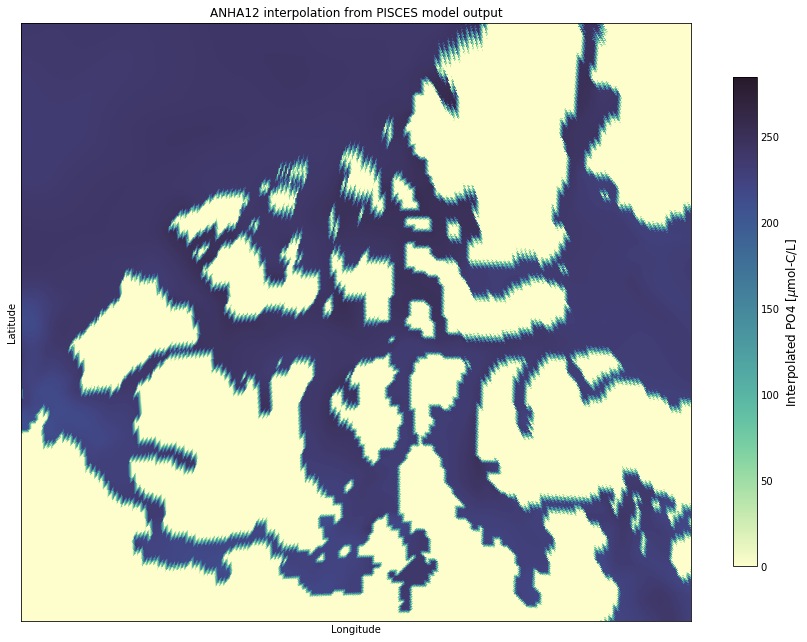

In [16]:
fig,ax = plt.subplots(figsize=(15,15))
proj=Basemap(projection='eqdc', lat_0=74, lon_0=-95, resolution='i', 
             llcrnrlon=-120, llcrnrlat=65, urcrnrlon=-50, urcrnrlat=80)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1);
# proj.fillcontinents(color=[0.75, 0.75, 0.75], lake_color=None, zorder=2);

# model:
x, y = proj(mlons, mlats)
scale = 10**6

# plot all together:
CS = proj.pcolor(x, y, PO4_2002[0,:,:]*scale, cmap=cmocean.cm.deep)
CBar = plt.colorbar(CS, shrink=0.6)
CBar.ax.tick_params(axis='y', length=0)
CBar.set_label('Interpolated PO4 [$\mu$mol-C/L]', fontsize=12)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('ANHA12 interpolation from PISCES model output')

### 4. Save to NetCDF file

In [17]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc','r')

# Load structure from sample dataset:
deptht = c.variables['deptht']
BX = c.dimensions['x']
BY = c.dimensions['y']

In [18]:
def save_PO4(filename, field):
    ncd = nc.Dataset(filename, 'w', zlib=True)
    nc_tools.init_dataset_attrs(
        ncd,
        title='dust input field',
        notebook_name='IC',
        nc_filepath='./dust_input.nc',
        comment='INCA dust deposition field')

    ncd.createDimension('x',len(BX))
    ncd.createDimension('y',len(BY))
    ncd.createDimension('deptht', len(deptht))
    
    # variables
    PO4_var = ncd.createVariable('PO4', 'float64', ('deptht','y','x'))
    PO4_var.units = 'mol-C/L'
    PO4_var.long_name = 'Nitrate concentration'  
    PO4_var.coordinates = 'nav_lon nav_lat deptht'
    PO4_var[:] = field
    
    nc_tools.check_dataset_attrs(ncd)
    ncd.close()
    return

In [19]:
save_PO4('PO4_2002.nc',PO4_2002)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 11:14:39] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references


In [20]:
save_PO4('PO4_2003.nc',PO4_2003)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 11:14:57] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references


In [23]:
save_PO4('PO4_2004.nc',PO4_2004)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 11:52:53] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references


In [24]:
save_PO4('PO4_2005.nc',PO4_2005)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 11:53:08] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references


In [28]:
save_PO4('PO4_2006.nc',PO4_2006)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 12:26:13] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references


In [29]:
save_PO4('PO4_2007.nc',PO4_2007)

file format: NETCDF4
Conventions: CF-1.6
title: dust input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-07-17 12:26:34] Created netCDF4 zlib=True dataset.
comment: INCA dust deposition field
Missing value for dataset attribute: references
